<font size="12">Organ_detecter</font>

# Setting up

## Importing libraries

In [1]:
import pandas as pd
import pathlib
import keras
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPool2D
from tensorflow.keras import models, layers, regularizers, Sequential

## Importing data

In [2]:
lung_diseases = ['Airspace_opacity','Bronchiectasis','interstitial_lung_disease','Nodule','normal','Parenchyma_destruction']
brain_diseases = ['acute_infarct','chronic_infarct','extra','focal_flair_hyper','intra','normal','white_matter_changes']
knee_diseases = ['acl_pathology','bone_inflammation','chondral_abnormality',
    'fracture','intra','meniscal_abnormality','normal','patella_pathology','pcl_pathology','soft_tissue_fluid_collection']
shoulder_diseases = ['acj_oa','biceps_pathology','ghj_oa','labral_pathology','marrow_inflammation','normal',
                     'osseous_lesion','post_op','soft_tissue_edema','soft_tissue_fluid','supraspinatus_pathology']
spine_diseases = ['cord_pathology','cystic_lesions','disc_pathology','normal','osseous_abn']



In [3]:
url_lung = [f'../Data/CT/Lung/{i}/' for i in lung_diseases]
url_brain= [f'../Data/MR/brain/{i}/' for i in brain_diseases]
url_knee = [f'../Data/MR/knee/{i}/' for i in knee_diseases]
url_shoulder = [f'../Data/MR/shoulder/{i}/' for i in shoulder_diseases]
url_spine= [f'../Data/MR/spine/{i}/' for i in spine_diseases]


In [4]:
limit = 100

In [5]:
images_lung = [cv2.imread(file) for path in url_lung for file in glob.glob(path + "*.png")]
images_brain = [cv2.imread(file) for path in url_brain for file in glob.glob(path + "*.png")]
images_knee = [cv2.imread(file) for path in url_knee for file in glob.glob(path + "*.png")]
images_shoulder = [cv2.imread(file) for path in url_shoulder for file in glob.glob(path + "*.png")]
images_spine = [cv2.imread(file) for path in url_spine for file in glob.glob(path + "*.png")]

In [6]:
labels_lung = [0] * len(images_lung)
labels_brain = [1] * len(images_brain)
labels_knee = [2] * len(images_knee)
labels_shoulder = [3] * len(images_shoulder)
labels_spine= [4] * len(images_spine)

## Checking data

In [7]:
lung_count = len(images_lung)
lung_count

3000

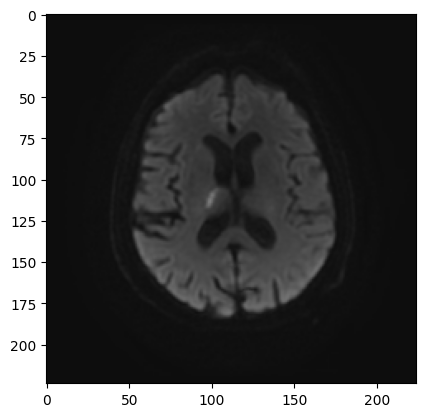

In [8]:
img = np.asarray(images_brain[0])
imgplot = plt.imshow(img)

# Model definition

In [9]:
def initialize_model():

    model = Sequential()

    model.add(layers.Conv2D(64, (3,3), activation="relu",input_shape=(224, 224, 3)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(64, (3,3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(32, (3,3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(32, (3,3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
              
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(100, activation='relu'))
   
    model.add(layers.Dense(5, activation='softmax'))
    
    ### Model compilation
    model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])
       
    
    return model

# Creating X and y for training and testing

In [10]:
X = np.concatenate((images_lung, images_brain, images_knee, images_shoulder, images_spine), axis=0)
y = np.concatenate((labels_lung, labels_brain, labels_knee, labels_shoulder, labels_spine), axis=0)

In [11]:
X.shape

(21139, 224, 224, 3)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [13]:
X_train.shape

(16911, 224, 224, 3)

In [14]:
y_train.shape

(16911,)

# Training the model

In [15]:
model = initialize_model()

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 32)        0

In [17]:
es = EarlyStopping(patience = 3, restore_best_weights=True)

history = model.fit(X_train, y_train, 
          epochs=10,
          batch_size=32,
          validation_split = 0.2,
          callbacks=[es],
          verbose=1)




Epoch 1/10
423/423 [==============================] - 223s 525ms/step - loss: 0.1954 - accuracy: 0.9698 - val_loss: 0.0263 - val_accuracy: 0.9938
Epoch 2/10
423/423 [==============================] - 193s 456ms/step - loss: 0.0288 - accuracy: 0.9921 - val_loss: 0.0166 - val_accuracy: 0.9965
Epoch 3/10
423/423 [==============================] - 190s 450ms/step - loss: 0.0119 - accuracy: 0.9969 - val_loss: 0.0249 - val_accuracy: 0.9950
Epoch 4/10
423/423 [==============================] - 198s 467ms/step - loss: 0.0159 - accuracy: 0.9964 - val_loss: 0.0229 - val_accuracy: 0.9956
Epoch 5/10
423/423 [==============================] - 188s 445ms/step - loss: 0.0051 - accuracy: 0.9989 - val_loss: 0.0307 - val_accuracy: 0.9959


# Testing the model and displaying results

In [18]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    
    # --- LOSS --- 
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- ACCURACY
    
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].set_ylim((0,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
    
    if title:
        fig.suptitle(title)

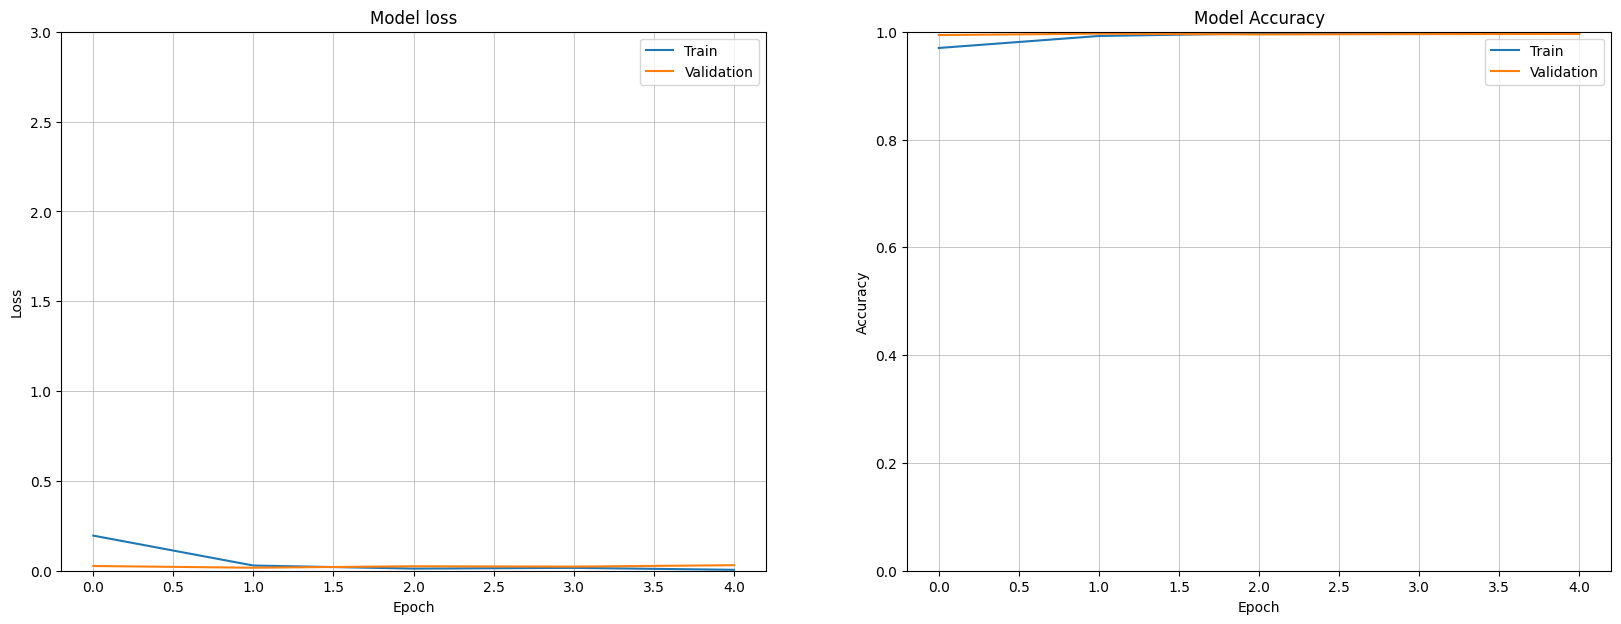

In [19]:
plot_loss_accuracy(history, title=None)

In [20]:
evaluation = model.evaluate(X_test, y_test)

133/133 [==============================] - 17s 126ms/step - loss: 0.0117 - accuracy: 0.9967


In [21]:
print(f'Model accuracy is {round(evaluation[1]*100,2)} %')

Model accuracy is 99.67 %


In [22]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)

133/133 [==============================] - 17s 124ms/step


In [23]:
results = pd.DataFrame(y_pred)
results['reels'] = y_test

In [24]:
results

,0,1,2,3,4,reels
0,0.0,0.0,0.0,0.0,1.0,4
1,0.0,1.0,0.0,0.0,0.0,1
2,0.0,1.0,0.0,0.0,0.0,1
3,0.0,0.0,1.0,0.0,0.0,2
4,0.0,0.0,1.0,0.0,0.0,2
...,...,...,...,...,...,...
4223,0.0,0.0,0.0,1.0,0.0,3
4224,0.0,0.0,0.0,1.0,0.0,3
4225,0.0,0.0,1.0,0.0,0.0,2
4226,0.0,0.0,0.0,0.0,1.0,4
